### Colorectal Cancer Data Analysis
The notebook is going to guide throught the exploration and analysis of the given colorectal cancer datset, composed by:
1. A gene expression dataset, containing raw counts of gene expression per patient;
2. A clinical dataset, containing clinical data for the patient of the aforementioned expression dataset.

Note: biopsy site and sample type have been used as covariates for the data aggregation.

These are the steps I have taken to perform the analysis:
1. Cleaning of the clinical dataset;
2. Exploration of the two datasets;
3. Possible analyses discussion;
4. Selected analyses.

In [1]:
import settings, data_loader, data_manipulator, plotter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
clinical_data = data_loader.load_clinical_data()

In [4]:
clinical_data.columns

Index(['Age', 'Age category', 'Biopsy subsite', 'BRAF mutation', 'Biopsy site',
       'Biopsy timepoint', 'CMS', 'Cancer type', 'Distal vs proximal',
       'Donor type', 'EGFR mutated', 'Grade', 'HER2 mutation',
       'Histological subtype', 'Histological type', 'KRAS mutation',
       'Line of treatment', 'MSI status', 'Molecular type', 'OS status',
       'OS time', 'Primary site', 'Prior treatment', 'PFS status', 'PFS time',
       'Sample type', 'Gender', 'Stage', 'TMB', 'TMB group', 'TP53 mutation',
       'Therapy response', 'Therapy type', 'Tumor type'],
      dtype='object')

### STEP 1: CLEAN DATASET ROWS
1. First I verify index uniqueness;
2. Then I verify the patients/donors ids uniqueness.

In [5]:
data_manipulator.verify_index_uniqueness(clinical_data)

True

then, verify that the gtex an tcga donors/participants are unique.

1. TCGA sample names have a barcode that specifies (also) the [participant id](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/).
2. GTEX sample names have as well a barcode that specifies (also) the [donor id](https://sites.google.com/broadinstitute.org/gtex-faqs/home).
3. GSM sample names have an unique identifier after the GSM. By checking that the index ids are unique, I already veryfied that the samples have unique donor.

In [6]:
data_manipulator.verify_all_index_participant_unique(clinical_data)

COLUMNS IN GTEX WHERE THERE IS DIFFERENCE BETWEEN ROWS WITH SAME DONOR: {('Biopsy subsite', 'Distal vs proximal')}

GTEX set is 555; list is 779.

COLUMNS IN TCGA WHERE THERE IS DIFFERENCE BETWEEN ROWS WITH SAME DONOR: {('Biopsy timepoint',), (), ('BRAF mutation',)}

TCGA set is 616; list is 631.



False

In [7]:
tcga_rows_to_consolidate = data_manipulator.get_double_donor_rows(clinical_data, 2, "TCGA")

In [8]:
for rows in tcga_rows_to_consolidate:
#     print(f"passing by {rows}")
    to_keep = data_manipulator.consolidate_columns(clinical_data.loc[rows])
#     print(f"To keep: {to_keep[0]}")
    rows.remove(to_keep[0])
    for row in rows:
        clinical_data.drop(row, axis=0, inplace=True)
    if len(to_keep)>1: 
        for col in to_keep[1]:
            clinical_data.loc[to_keep[0],col] = np.nan

rows agree? False
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? True
rows agree? False
rows agree? False


Comment:  
1. GTEX has samples from the same donor in different places (distal and proximal colon). I can use this for analysis between distal and proximal expression. (normal vs tumor in distal or proximal). At this point I keep both samples from the same donor. This way I could do a differential analysis based on the place where the tumor is coming from, having healthy data on both places.
2. TCGA has differences in the same samples that are more diverse, usually one sample has less data than the other (so I keep the one with more data) and I set as NANs all the values from columns that disagree (like mutation WT or MUTATED).

Plotting NaNs pattern

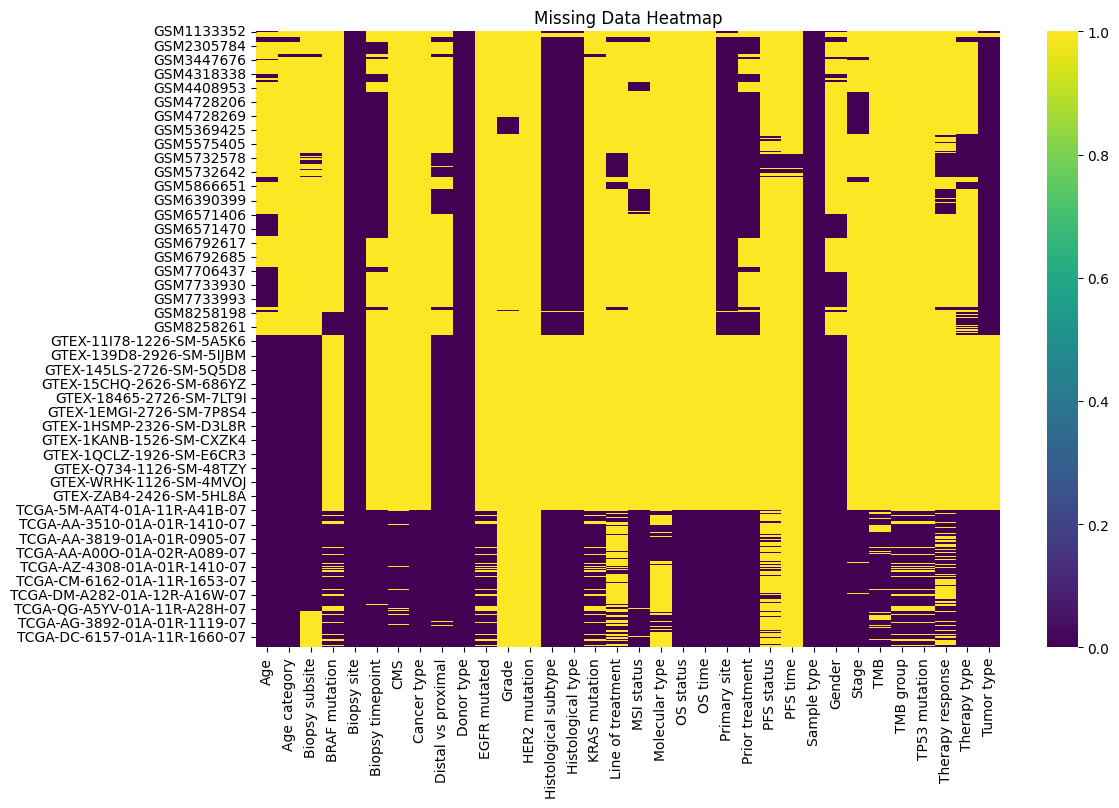

In [9]:
data_manipulator.exploreNaNs(clinical_data)

Consideration: this dataset is a collage of clinical data from 3 different datasets: 
1. GSM is referred to Gene Expression Omnibus data. It contains both tumor and normal tissue samples.
2. GTEX is referred to Genotype-Tissue Expression and it contains non-disease tissue samples.
3. TCGA is referred to The Cancer Genome Atlas and contains primary cancer and matched normal samples.

Verifying that the indexes have as prefix only "GSM", "GTEX", "TCGA"

In [10]:
data_manipulator.verify_clinical_df_index_prefixes(clinical_data)

GSM has 1360
GTEX has 779
TCGA has 616
All rows are in GSM, GTEX, TCGA


I now add a column flagging the dataset of origin to then verify if batch effects is (still in place)

In [11]:
clinical_data["source"] = data_manipulator.infer_dataset_from_index(clinical_data)

In [12]:
clinical_data["source"].unique()

array(['GSM', 'GTEX', 'TCGA'], dtype=object)

Listing out all columns names:

In [13]:
list(clinical_data.columns.values)

['Age',
 'Age category',
 'Biopsy subsite',
 'BRAF mutation',
 'Biopsy site',
 'Biopsy timepoint',
 'CMS',
 'Cancer type',
 'Distal vs proximal',
 'Donor type',
 'EGFR mutated',
 'Grade',
 'HER2 mutation',
 'Histological subtype',
 'Histological type',
 'KRAS mutation',
 'Line of treatment',
 'MSI status',
 'Molecular type',
 'OS status',
 'OS time',
 'Primary site',
 'Prior treatment',
 'PFS status',
 'PFS time',
 'Sample type',
 'Gender',
 'Stage',
 'TMB',
 'TMB group',
 'TP53 mutation',
 'Therapy response',
 'Therapy type',
 'Tumor type',
 'source']

Consideration: columns refer to different kind of data. There is 
1. 'anagraphic' data (like age and gender);
2. marker data (like known genes mutation, TMB, CMS, MSI);
3. tumor-specific data (like cancer/tumor type, donor, grade, stage)
4. clinical data (like treatment, therapy, OS).

I will divide these data into different categories as it can be used for different analysis directions.  
Moreover, as GTEX contains normal tissue samples, it lacks labels in most of non-anagraphic columns.

### STEP 2 - CLEANING THE CLINICAL DATASET COLUMNS

#### Aggregating the tumor sample origin data (columns Biopsy subsite, Biopsy site, Primary site, Distal vs Proximal)
Based on [this report](https://www.cancer.org/content/dam/cancer-org/research/cancer-facts-and-statistics/colorectal-cancer-facts-and-figures/colorectal-cancer-facts-and-figures-2023.pdf) I can see that the colorectal cancer is labled to be found into 4 sites: Colon, Rectum, Colorectum, Rectosigmoid junction. 
There is redundancy given by the columns "biopsy site" and "primary site" as they both specify one of the 4 primary sites.

Moreover, as the colon is a quite large organ, it can be specified in left or right colon. Left colon is also called distal, while right colon is also called proximal.
This means that biopsy subsite (which contains only left or right column values) and distal vs proximal (which contain distal or proximal values) are redundant.

I cannot collapse all 4 columns into 1 as not all columns whose site is column have a distinction into distal or proximal.

First I validate that the two columns correspond

In [14]:
column_1 = 'Biopsy site'
column_2 = 'Primary site'

for biopsy_site in settings.BIOPSY_SITES:
    discordance_mask = data_manipulator.verify_concordance_columns_on_value(clinical_data, column_1, column_2, biopsy_site)
    print(f"FOUND {discordance_mask.sum()} discordant rows for value '{biopsy_site}' between '{column_1}' and '{column_2}'")

FOUND 0 discordant rows for value 'Colon' between 'Biopsy site' and 'Primary site'
FOUND 0 discordant rows for value 'Rectum' between 'Biopsy site' and 'Primary site'
FOUND 0 discordant rows for value 'Colorectum' between 'Biopsy site' and 'Primary site'
FOUND 0 discordant rows for value 'Rectosigmoid junction' between 'Biopsy site' and 'Primary site'


As "Biopsy site" does not have NaNs, I just drop "Primary site"

In [15]:
clinical_data.drop("Primary site", axis=1, inplace=True)

Then I merge "Biopsy subsite" and "Distal vs Proximal"

In [16]:
subsite_mapping: dict = {"Right colon": "Proximal", "Left colon": "Distal"}

In [17]:
clinical_data['Biopsy subsite'] = clinical_data['Biopsy subsite'].map(subsite_mapping)

In [18]:
clinical_data['colon_subsite'] = clinical_data['Distal vs proximal'].combine_first(clinical_data['Biopsy subsite'])

In [19]:
clinical_data = clinical_data.drop('Distal vs proximal', axis=1)

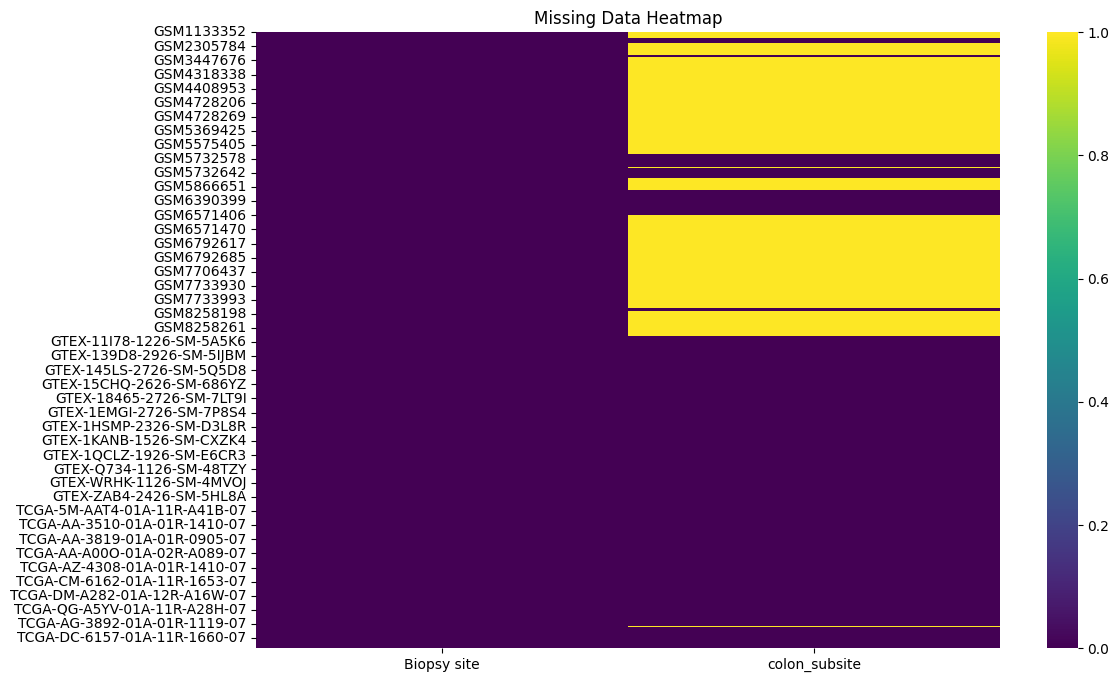

In [20]:
data_manipulator.exploreNaNs(clinical_data[["Biopsy site", "colon_subsite"]])

Dropping some columns not very useful

In [21]:
clinical_data = clinical_data.drop(settings.DROP_SELECTED_COLUMS, axis=1)

Dividing age into categories (based on [this report](https://www.cancer.org/content/dam/cancer-org/research/cancer-facts-and-statistics/colorectal-cancer-facts-and-figures/colorectal-cancer-facts-and-figures-2023.pdf)

In [22]:
#data_manipulator.verify_column2_subset_comun1(clinical_data, "Age", 'Age category').sum()

In [23]:
list(clinical_data.columns.values)
df_tumor = clinical_data[[el for el in settings.TUMOR_METRICS if el not in settings.DROP_SELECTED_COLUMS]]

In [24]:
df_tumor.describe()

Donor type Grade Histological subtype Histological type Stage
count        2755    79                 1951              1951   821
unique          2     3                   14                 5     4
top         Tumor    II       Adenocarcinoma          Neoplasm   III
freq         1951    45                  842               974   300

In [25]:
for col in df_tumor.columns:
    data_manipulator.print_counts(df_tumor, col)

----------
Donor type counts: Donor type
Tumor     1951
Normal     804
Name: count, dtype: Int64

----------
Grade counts: Grade
II     45
III    26
I       8
Name: count, dtype: Int64

----------
Histological subtype counts: Histological subtype
Adenocarcinoma                                        842
Malignant tumor                                       738
Unknown behavior neoplasm                             132
Neoplasm, metastatic                                  104
Mucinous adenocarcinoma                                79
Carcinoma                                              23
Adenocarcinoma, metastatic, NOS                        10
Adenocarcinoma in tubulovillous adenoma                 8
Tubular adenocarcinoma                                  5
Metastatic carcinoma                                    3
Adenocarcinoma with mixed subtypes                      3
Papillary adenocarcinoma, NOS                           2
Adenocarcinoma with neuroendocrine differentiation      1

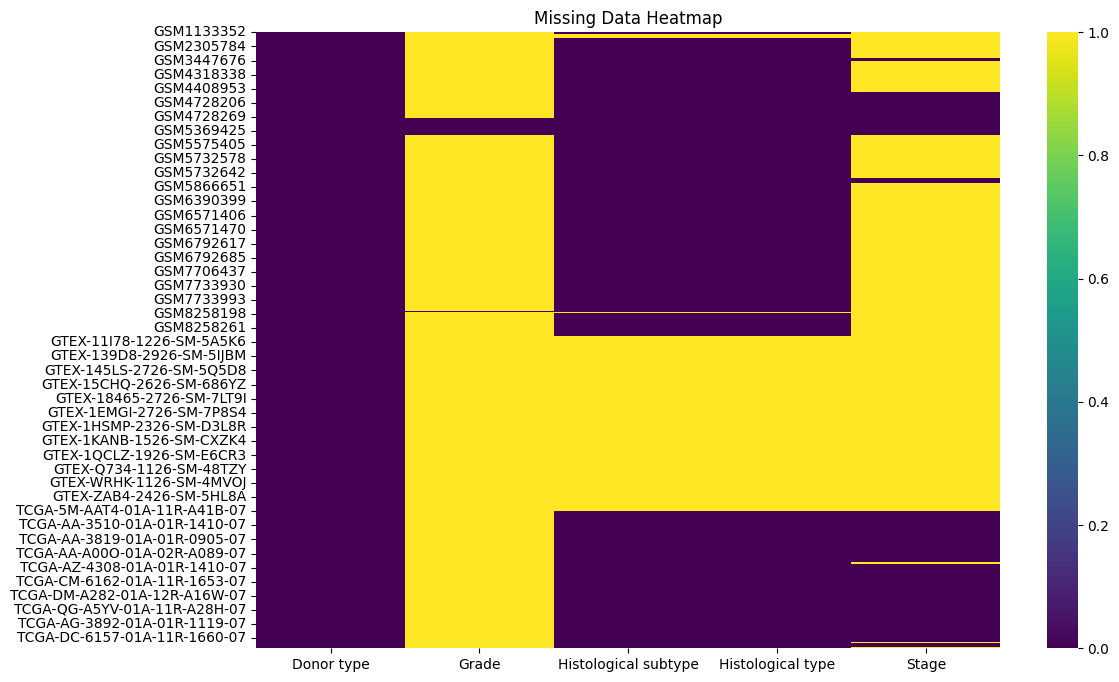

In [26]:
data_manipulator.exploreNaNs(df_tumor)

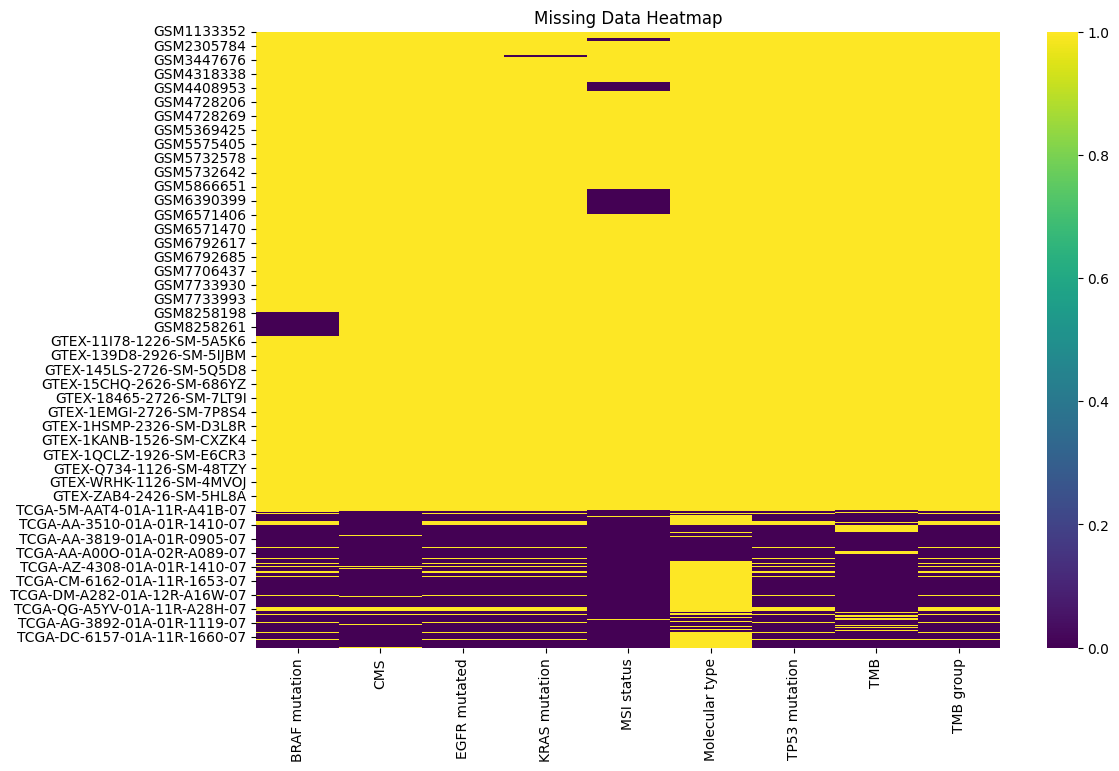

In [27]:
df_mutations = clinical_data[[el for el in settings.MUTATION_METRICS if el not in settings.DROP_SELECTED_COLUMS]]
data_manipulator.exploreNaNs(df_mutations)

In [28]:
df_mutations["TMB group"].unique()

<StringArray>
[<NA>, 'Low', 'High']
Length: 3, dtype: string

Setting the TMB group HIGH if > 10 else LOW.

In [29]:
# df_mutations[df_mutations["TMB group"] == 'High']["TMB"].describe()
# df_mutations[df_mutations["TMB group"] == 'Low']["TMB"].describe()
threshold = 10

has_value = pd.notna(df_mutations["TMB"])

# Only update rows where float_col has values
df_mutations.loc[has_value, "TMB group"] = np.where(
    df_mutations.loc[has_value, "TMB"] >= threshold,
    'High',
    'Low'
)

df_mutations = df_mutations.drop("TMB", axis=1)

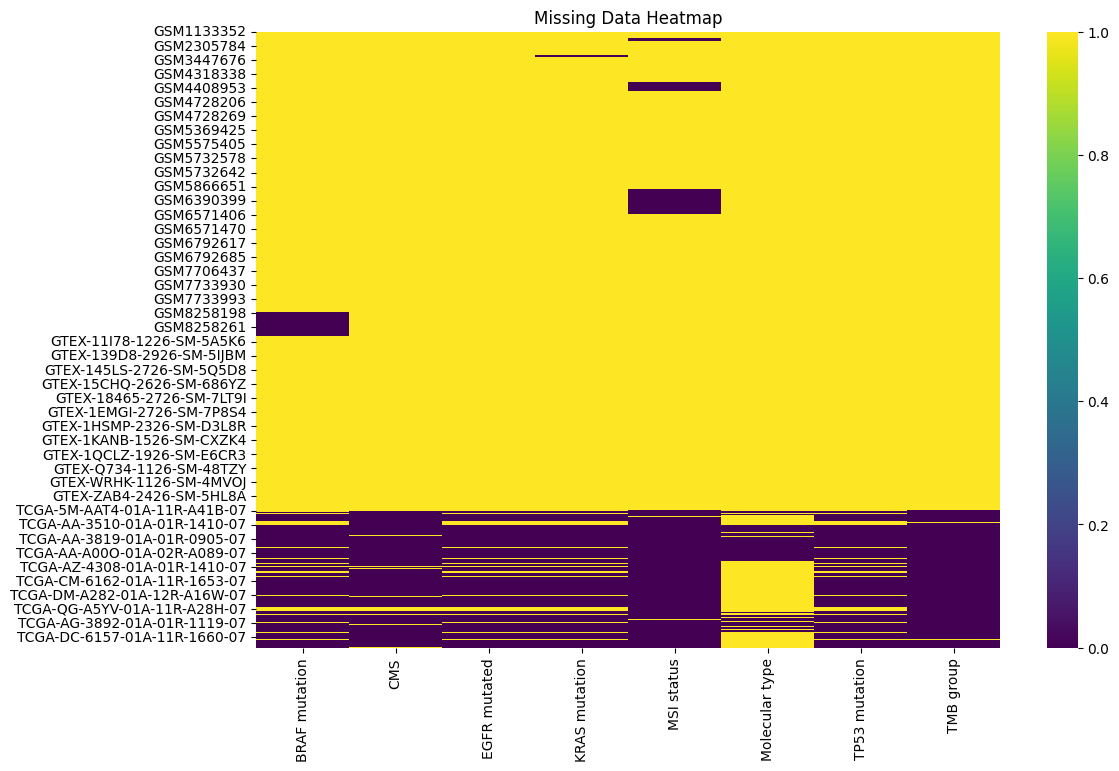

In [30]:
data_manipulator.exploreNaNs(df_mutations)

Consideration: any analysis on mutations is going to be done only on TCGA samples, i.e. the only ones that have actual data on it.
I check the # of elements for each unique label in the columns to see if there are enough of both to do an analysis or is it better to drop.

In [31]:
for col in df_mutations.columns:
    data_manipulator.print_counts(df_mutations, col)

----------
BRAF mutation counts: BRAF mutation
WT         560
Mutated     56
Name: count, dtype: Int64

----------
CMS counts: CMS
CMS2     219
CMS4     139
CMS1      76
CMS3      72
NOLBL     60
Name: count, dtype: Int64

----------
EGFR mutated counts: EGFR mutated
WT         498
Mutated     15
Name: count, dtype: Int64

----------
KRAS mutation counts: KRAS mutation
WT         297
Mutated    226
Name: count, dtype: Int64

----------
MSI status counts: MSI status
MSS      544
MSI-H    128
MSI-L    102
Name: count, dtype: Int64

----------
Molecular type counts: Molecular type
CIMP-low                               41
Cluster 3                              40
Chromosomal instability | Cluster 4    40
Chromosomal instability | Cluster 3    36
CIMP-high                              35
Cluster 4                              30
Chromosomal instability | CIMP-low      8
Chromosomal instability | CIMP-high     1
Name: count, dtype: Int64

----------
TP53 mutation counts: TP53 mutation
Mutat

In [32]:
clinical_data = clinical_data.drop("EGFR mutated", axis=1)

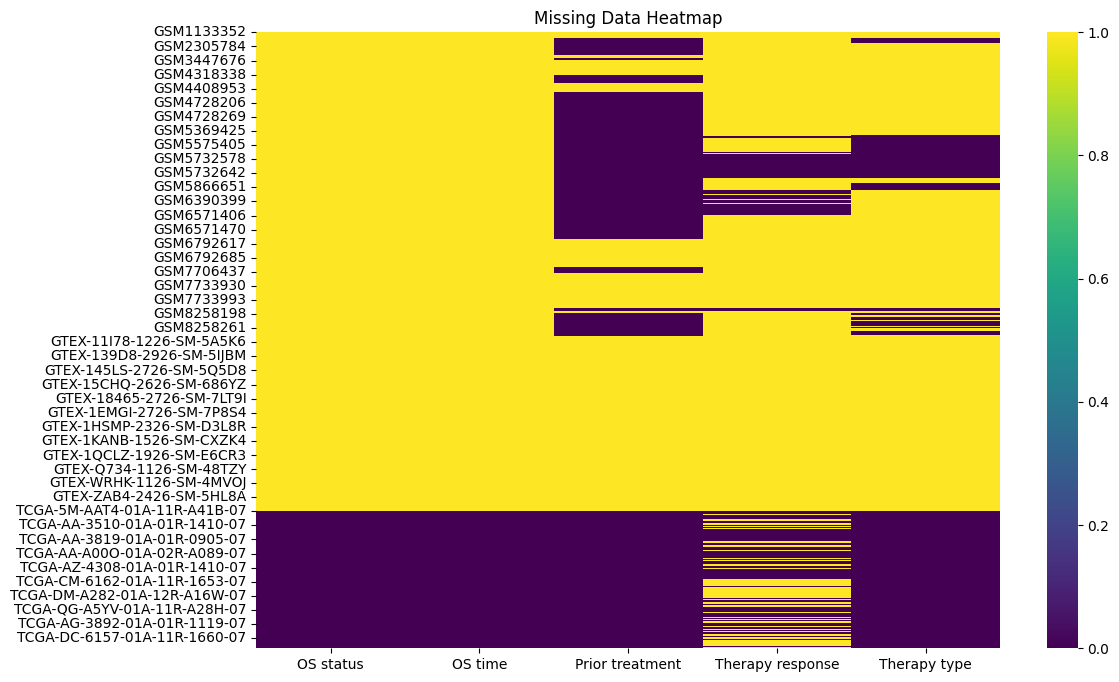

In [33]:
df_clinical = clinical_data[[el for el in settings.CLINICAL_METRICS if el not in settings.DROP_SELECTED_COLUMS]]
data_manipulator.exploreNaNs(df_clinical)

In [34]:
for col in df_clinical.columns:
    data_manipulator.print_counts(df_clinical, col)

----------
OS status counts: OS status
Censored    488
Dead        128
Name: count, dtype: Int64

----------
OS time counts: OS time
0      29
31     14
457     8
30      8
61      7
       ..
532     1
97      1
357     1
159     1
371     1
Name: count, Length: 390, dtype: Int64

----------
Prior treatment counts: Prior treatment
No     1403
Yes     130
Name: count, dtype: Int64

----------
Therapy response counts: Therapy response
CR       336
nonCR    161
PD        59
PR        18
SD         9
Name: count, dtype: Int64

----------
Therapy type counts: Therapy type
Not available | Radiotherapy                              205
Radiotherapy | Not available                              183
Chemotherapy | Radiotherapy                               111
Targeted therapy                                          100
Targeted therapy + Chemotherapy                            84
Radiotherapy | Chemotherapy                                80
Chemotherapy                                         

In [35]:
df_demographics = clinical_data[settings.ANAGRAPHIC_METRICS]

#### removing duplicate gtex samples for demographics
As gtex has some samples that come from the same donors but from different locations, I drop the one in excess when analyzing the demographics

In [36]:
gtex_rows_to_consolidate = data_manipulator.get_double_donor_rows(df_demographics, 1, "GTEX")
to_drop = []
for rows in gtex_rows_to_consolidate:
    to_drop.extend(rows[1:])
    
df_demographics = df_demographics.drop(to_drop, axis=0)

In [37]:
for col in df_demographics.columns:
    data_manipulator.print_counts(df_demographics, col)

----------
Age counts: Age
54    191
64    177
44    101
34     61
24     55
     ... 
32      2
25      2
30      1
27      1
28      1
Name: count, Length: 65, dtype: Int64

----------
Gender counts: Gender
M    891
F    603
Name: count, dtype: Int64



### STEP 3: PLOT METRICS

#### demographics metrics: Age distribution by gender of the data

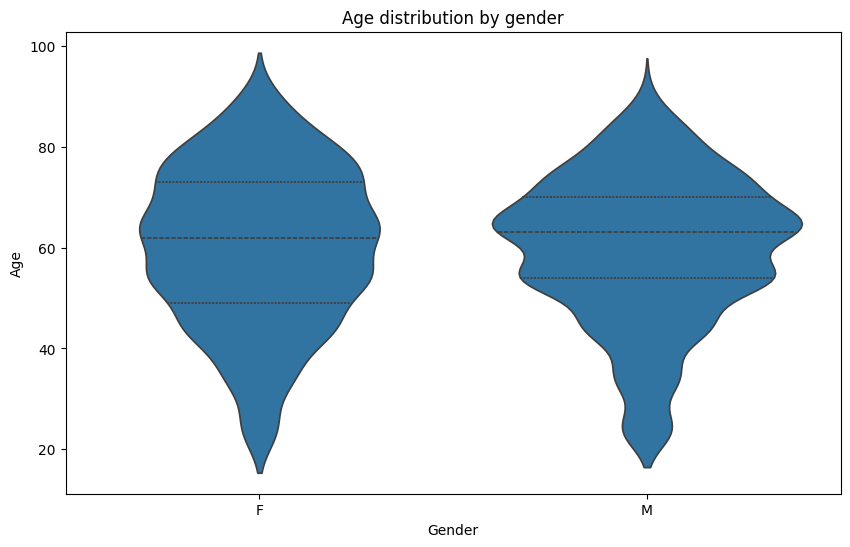

In [38]:
plotter.violin_xy(df_demographics, 'Gender', 'Age', 'Age distribution by gender')

#### MUTATIONS: co-occurrence between Micro-Satellite stability and Tumor Mutational Bourden
Rationale: MSI status can be Instable-high, Instable-low and Stable. Tumor Mutational Bourden can be high and low.
As both metrics are related to number of mutations, it might be possible that they are associated.  
Plotting the number of occurrences for each possible pair shows if there is any correlation.

In [39]:
mutation_occurence = pd.crosstab(df_mutations['MSI status'], df_mutations['TMB group'])
print(mutation_occurence)

TMB group   High  Low
MSI status           
MSI-H         80    6
MSI-L          2   99
MSS           10  403


In [40]:
type(mutation_occurence)

pandas.core.frame.DataFrame

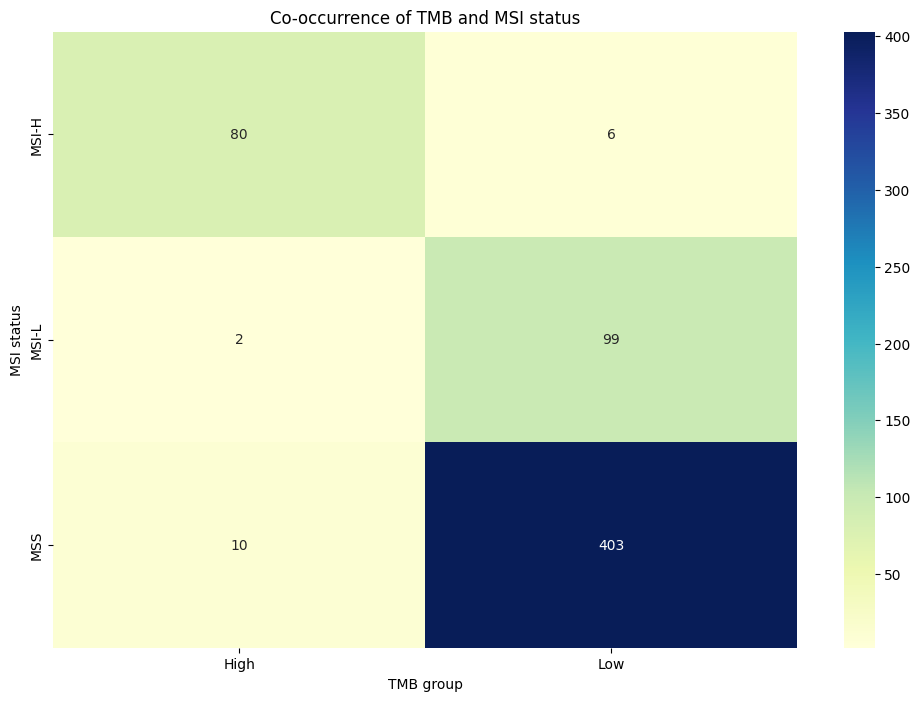

In [41]:
plotter.heatmap(mutation_occurence, "TMB group", "MSI status", "Co-occurrence of TMB and MSI status", colormap='YlGnBu')

### STEP 4: LOADING AND PREPROCESSING EXPRESSION DATA

In [42]:
# load expression dataset
expression_data = data_loader.load_expression_data()
expression_data.shape

(22723, 2770)

Straight away I remove the samples excluded by the clinical dataset

In [43]:
expression_data = expression_data.loc[:,expression_data.columns.isin(clinical_data.index)]
expression_data.shape

(22723, 2755)

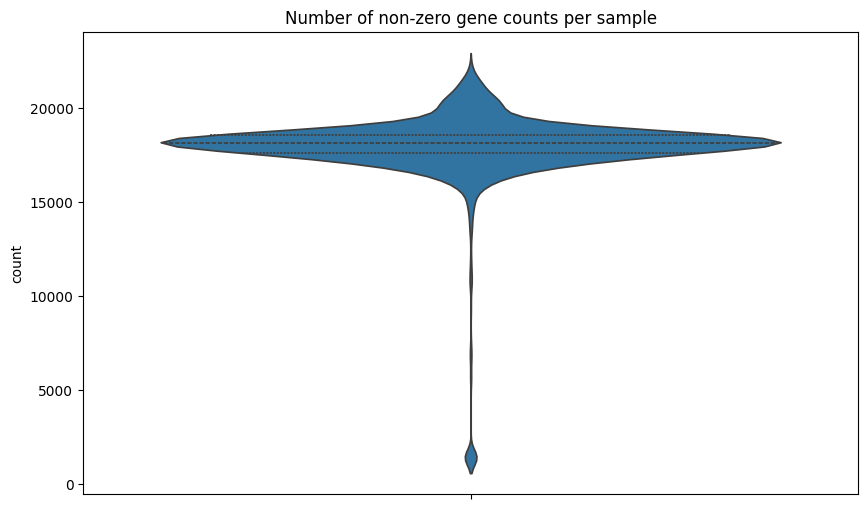

In [44]:
# violin plot of # of genes whose count != 0 
# choose a cutoff if needed to discard non-informative samples
non_zero_column_counts = (expression_data != 0).sum()
non_zero_column_count_df = pd.DataFrame(non_zero_column_counts, columns=['count'])

plotter.violin_y(non_zero_column_count_df, 'count', 'Number of non-zero gene counts per sample')

In [47]:
column_count_threshold = 15000
non_zero_column_count_df[non_zero_column_count_df['count'] < column_count_threshold].count()

count    57
dtype: int64

In [48]:
col_to_drop = non_zero_column_count_df[non_zero_column_count_df['count'] < column_count_threshold].index

Based on this plot I will set a cutoff od 15k genes for a sample to be accepted. This discards 57 samples.

In [49]:
expression_data = expression_data.drop(col_to_drop, axis=1)

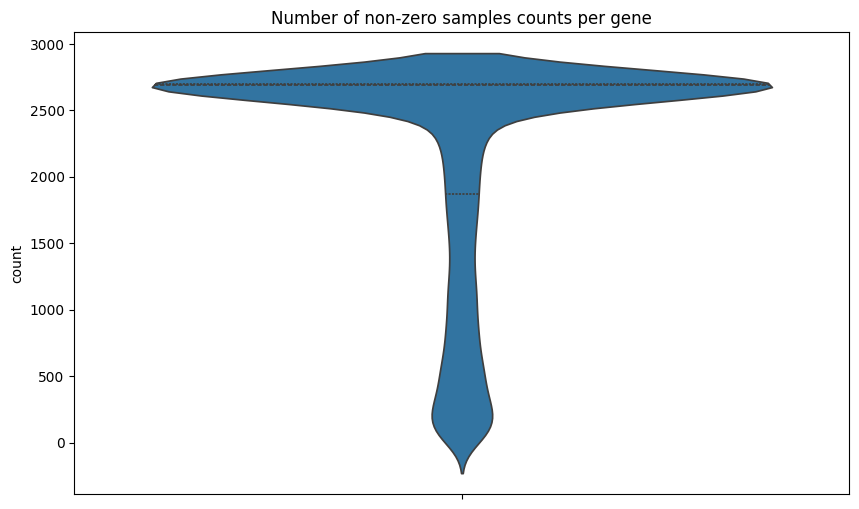

In [55]:
# filter also the genes and take out the ones that occurr in < 10% of samples
non_zero_row_count = (expression_data != 0).sum(axis=1)
non_zero_row_count_df = pd.DataFrame(non_zero_row_count, columns=['count'])

plotter.violin_y(non_zero_row_count_df, 'count', 'Number of non-zero samples counts per gene')

Filtering the expression data of genes that occurr on less than 10% of the samples.

In [59]:
min_samples = int(0.1 * expression_data.shape[1])
print(min_samples)
non_zero_row_count_df[non_zero_row_count_df['count'] < min_samples].count()

269


count    1425
dtype: int64

In [60]:
row_to_drop = non_zero_row_count_df[non_zero_row_count_df['count'] < 270].index
row_to_drop

Index(['AC006455.5', 'AC008175.1', 'AC016687.3', 'AC019155.2', 'AC021355.1',
       'AC023136.1', 'AC025428.1', 'AC025674.2', 'AC068075.1', 'AC083864.3',
       ...
       'VWC2L-IT1', 'WSPAR', 'XAGE5', 'XIRP2-AS1', 'XKRY', 'XKRY2', 'YY1P2',
       'ZCCHC13', 'ZNF385D-AS2', 'ZNF705B'],
      dtype='object', length=1431)

In [61]:
expression_data = expression_data.drop(row_to_drop, axis=0)

##### now passing to log data to reduce skewness

In [62]:
expr_normalized = data_manipulator.normalize_expression_data(expression_data)

#### EXPLORATORY ANALYSIS OF EXPRESSION DATA

In [63]:
# Create PCA dataframe
num_components = 4
pca_df, pca = data_manipulator.get_pca_dataframe(expr_normalized, expression_data.columns, num_components)

In [64]:
pca_df

PC1         PC2        PC3        PC4
GSM1133352                   -361.108875  -81.923309 -42.137057 -26.009779
GSM1133353                   -374.656634 -110.995349 -45.347527 -29.444113
GSM2042099                    -64.761443   27.191878  -2.691896   3.662277
GSM2042100                    -69.229643    3.550196 -11.545511   3.679095
GSM2042101                    103.609298   34.051056  62.225033  38.519662
...                                  ...         ...        ...        ...
TCGA-F5-6864-01A-11R-1928-07   76.871504   41.474397  -9.118913  13.777425
TCGA-G5-6233-01A-11R-1736-07   42.773992   62.141374 -11.584937  17.705242
TCGA-G5-6235-01A-11R-1736-07   36.572606   71.998731  -9.200341  10.490336
TCGA-G5-6572-01A-11R-1830-07   58.411612   46.916568 -12.622125   5.051439
TCGA-G5-6641-01A-11R-A32Z-07   48.911278   66.333803 -14.054770  15.221227

[2698 rows x 4 columns]

In [65]:
# Merge with clinical data
pca_df_merged = pca_df.merge(clinical_data, left_index=True, right_index=True)
pca_df_merged

PC1         PC2        PC3        PC4  \
GSM1133352                   -361.108875  -81.923309 -42.137057 -26.009779   
GSM1133353                   -374.656634 -110.995349 -45.347527 -29.444113   
GSM2042099                    -64.761443   27.191878  -2.691896   3.662277   
GSM2042100                    -69.229643    3.550196 -11.545511   3.679095   
GSM2042101                    103.609298   34.051056  62.225033  38.519662   
...                                  ...         ...        ...        ...   
TCGA-F5-6864-01A-11R-1928-07   76.871504   41.474397  -9.118913  13.777425   
TCGA-G5-6233-01A-11R-1736-07   42.773992   62.141374 -11.584937  17.705242   
TCGA-G5-6235-01A-11R-1736-07   36.572606   71.998731  -9.200341  10.490336   
TCGA-G5-6572-01A-11R-1830-07   58.411612   46.916568 -12.622125   5.051439   
TCGA-G5-6641-01A-11R-A32Z-07   48.911278   66.333803 -14.054770  15.221227   

                               Age Biopsy subsite BRAF mutation  \
GSM1133352                      80            NaN          <NA>   
GSM1133353                      80            NaN          <NA>   
GSM2042099                    <NA>            NaN          <NA>   
GSM2042100                    <NA>            NaN          <NA>   
GSM2042101                    <NA>            NaN          <NA>   
...                            ...            ...           ...   
TCGA-F5-6864-01A-11R-1928-07    74            NaN            WT   
TCGA-G5-6233-01A-11R-1736-07    74            NaN            WT   
TCGA-G5-6235-01A-11R-1736-07    72            NaN            WT   
TCGA-G5-6572-01A-11R-1830-07    56            NaN            WT   
TCGA-G5-6641-01A-11R-A32Z-07    67            NaN            WT   

                                        Biopsy site Biopsy timepoint    CMS  \
GSM1133352                                    Colon             <NA>   <NA>   
GSM1133353                                    Colon             <NA>   <NA>   
GSM2042099                                    Colon             <NA>   <NA>   
GSM2042100                                    Colon             <NA>   <NA>   
GSM2042101                                    Colon             <NA>   <NA>   
...                                             ...              ...    ...   
TCGA-F5-6864-01A-11R-1928-07                 Rectum     At diagnosis   CMS4   
TCGA-G5-6233-01A-11R-1736-07                 Rectum     At diagnosis  NOLBL   
TCGA-G5-6235-01A-11R-1736-07  Rectosigmoid junction     At diagnosis   CMS2   
TCGA-G5-6572-01A-11R-1830-07  Rectosigmoid junction             <NA>   CMS4   
TCGA-G5-6641-01A-11R-A32Z-07  Rectosigmoid junction     At diagnosis   <NA>   

                             Donor type Grade     Histological subtype  \
GSM1133352                        Tumor  <NA>     Metastatic carcinoma   
GSM1133353                        Tumor  <NA>     Metastatic carcinoma   
GSM2042099                        Tumor  <NA>           Adenocarcinoma   
GSM2042100                        Tumor  <NA>           Adenocarcinoma   
GSM2042101                        Tumor  <NA>           Adenocarcinoma   
...                                 ...   ...                      ...   
TCGA-F5-6864-01A-11R-1928-07      Tumor  <NA>           Adenocarcinoma   
TCGA-G5-6233-01A-11R-1736-07      Tumor  <NA>           Adenocarcinoma   
TCGA-G5-6235-01A-11R-1736-07      Tumor  <NA>           Adenocarcinoma   
TCGA-G5-6572-01A-11R-1830-07      Tumor  <NA>           Adenocarcinoma   
TCGA-G5-6641-01A-11R-A32Z-07      Tumor  <NA>  Mucinous adenocarcinoma   

                                                  Histological type  \
GSM1133352                                      Epithelial neoplasm   
GSM1133353                                      Epithelial neoplasm   
GSM2042099                             Adenomas and adenocarcinomas   
GSM2042100                             Adenomas and adenocarcinomas   
GSM2042101                             Adenomas and adenocarcinomas   
...                            

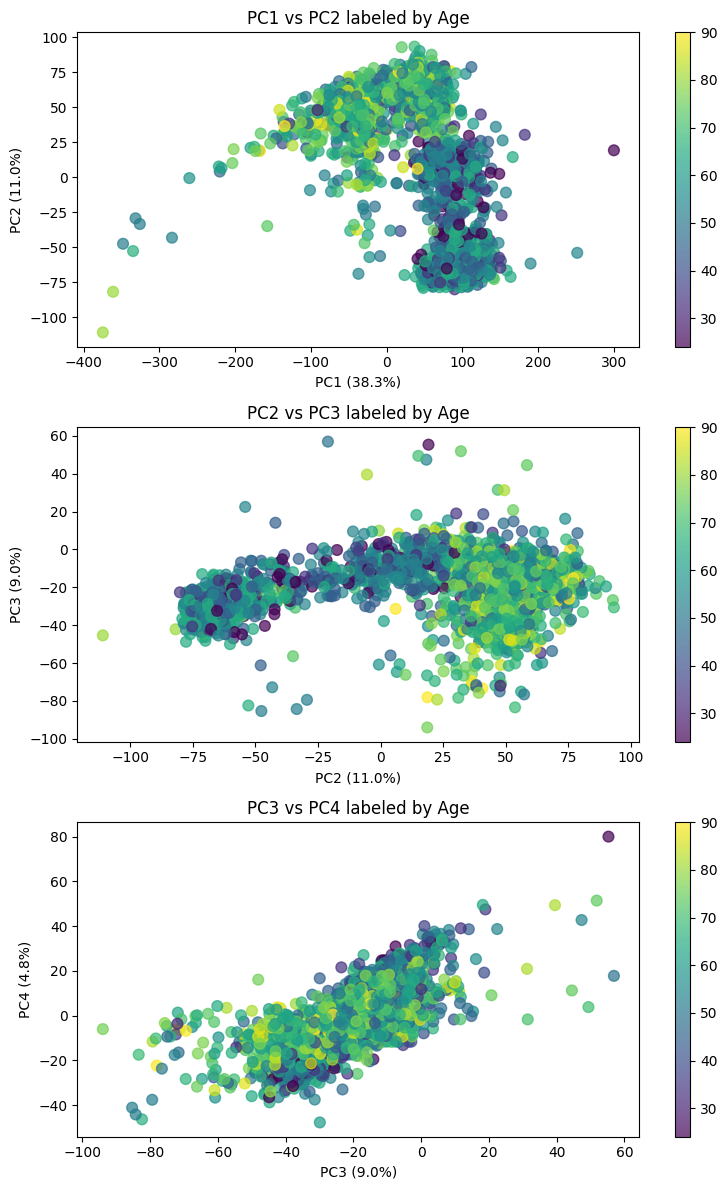

In [66]:
# Plot PCA colored by different variables
plotter.pca_components(pca_df_merged, pca, 'Age', 4)

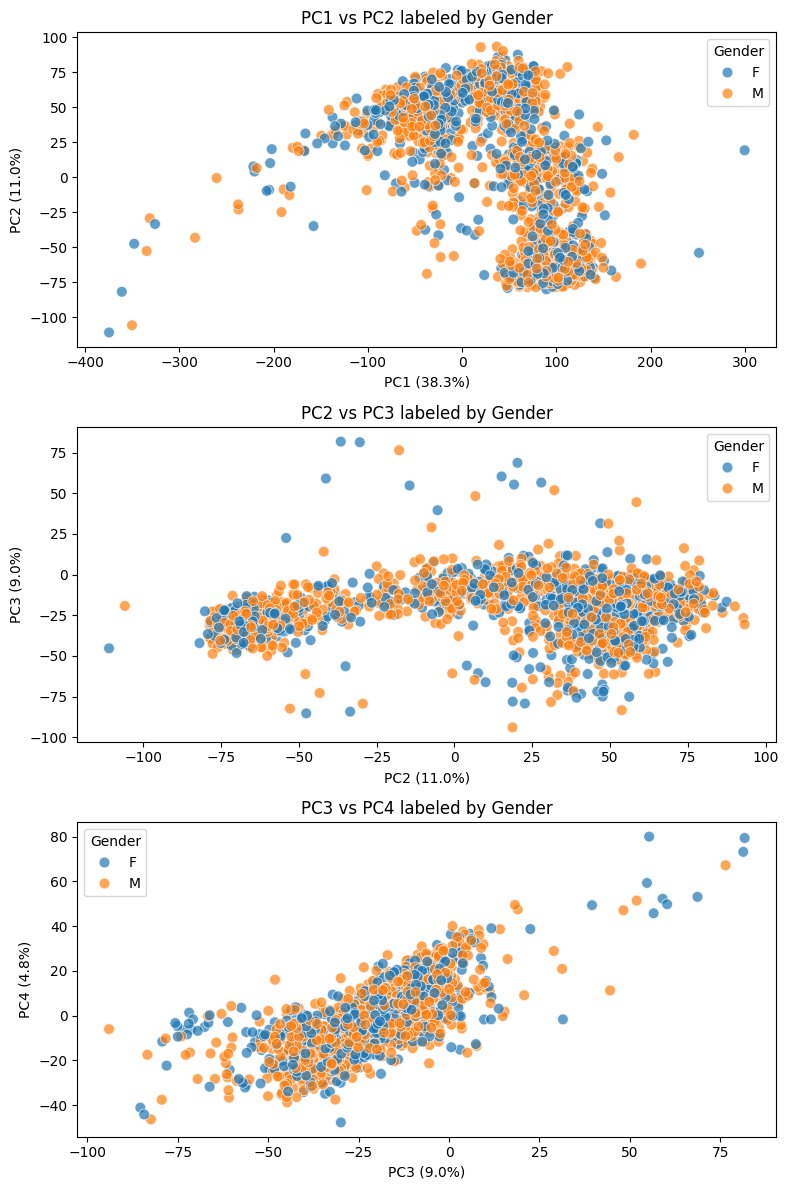

In [67]:
plotter.pca_components(pca_df_merged, pca, 'Gender', 4)

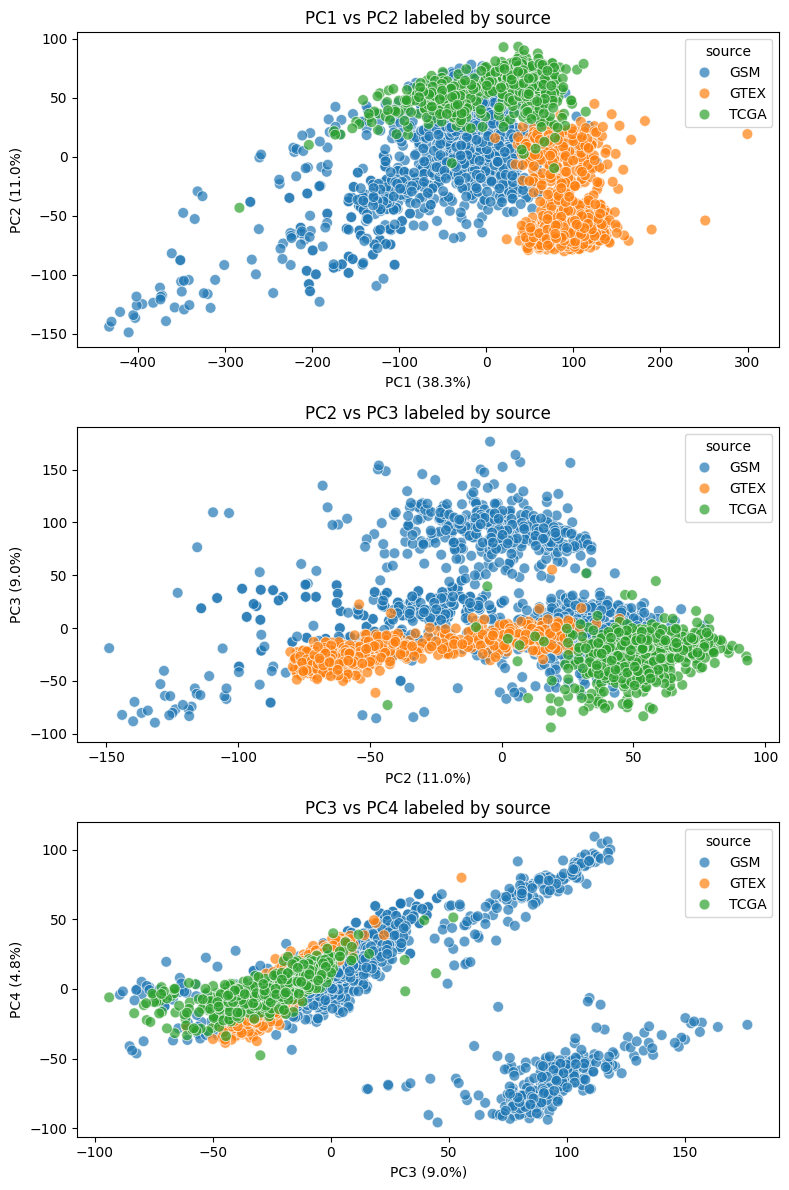

In [68]:
plotter.pca_components(pca_df_merged, pca, 'source', 4) 

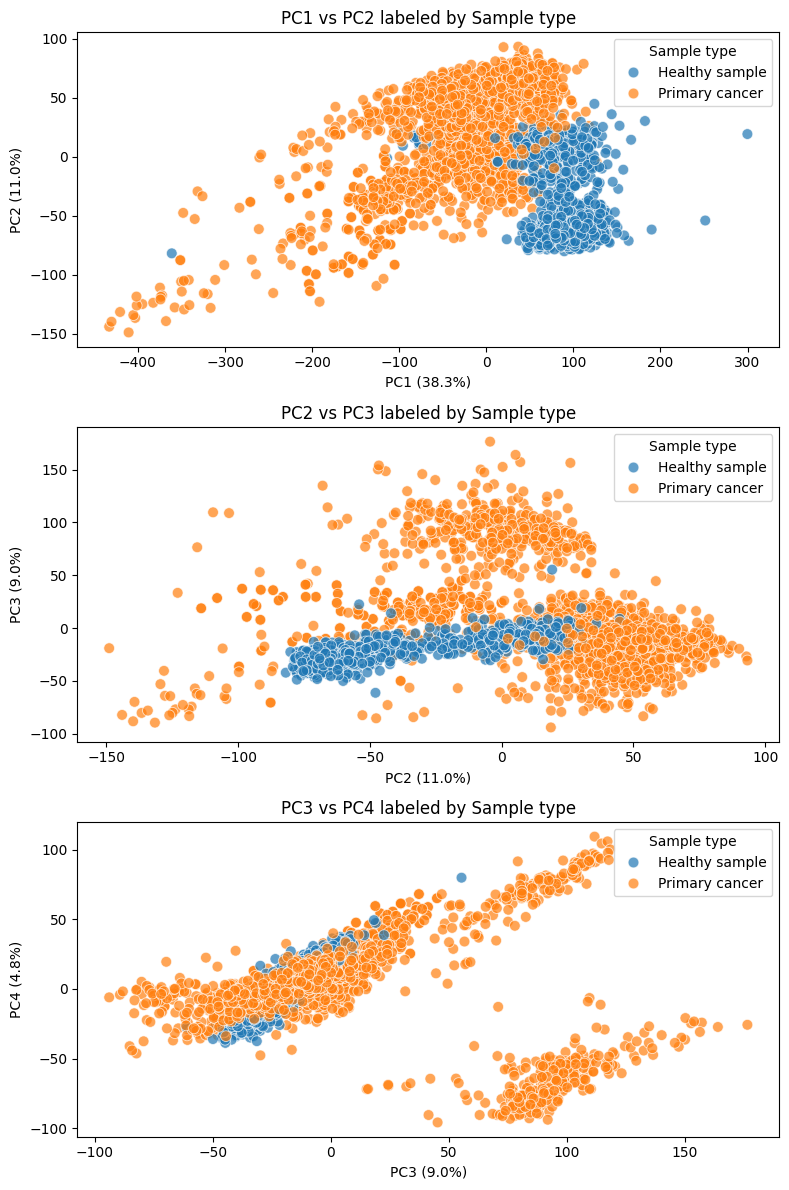

In [69]:
plotter.pca_components(pca_df_merged, pca, 'Sample type', 4) 

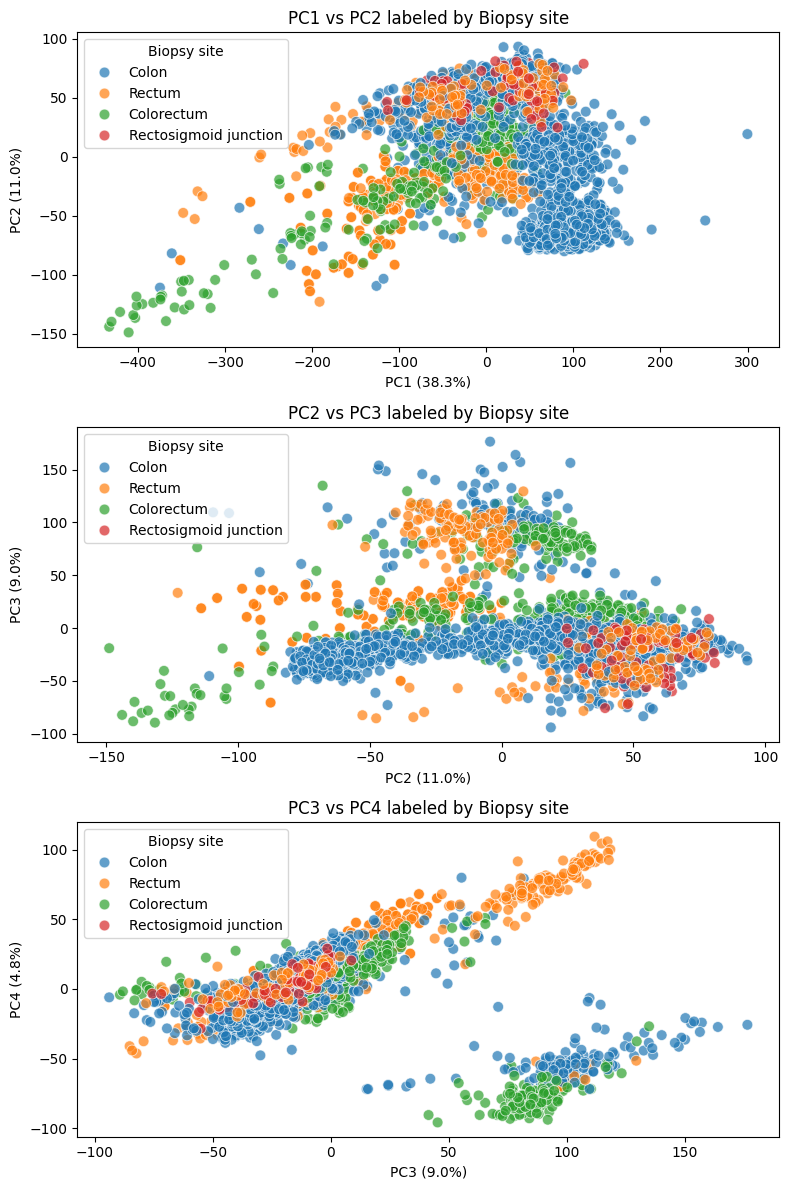

In [70]:
plotter.pca_components(pca_df_merged, pca, 'Biopsy site', 4)

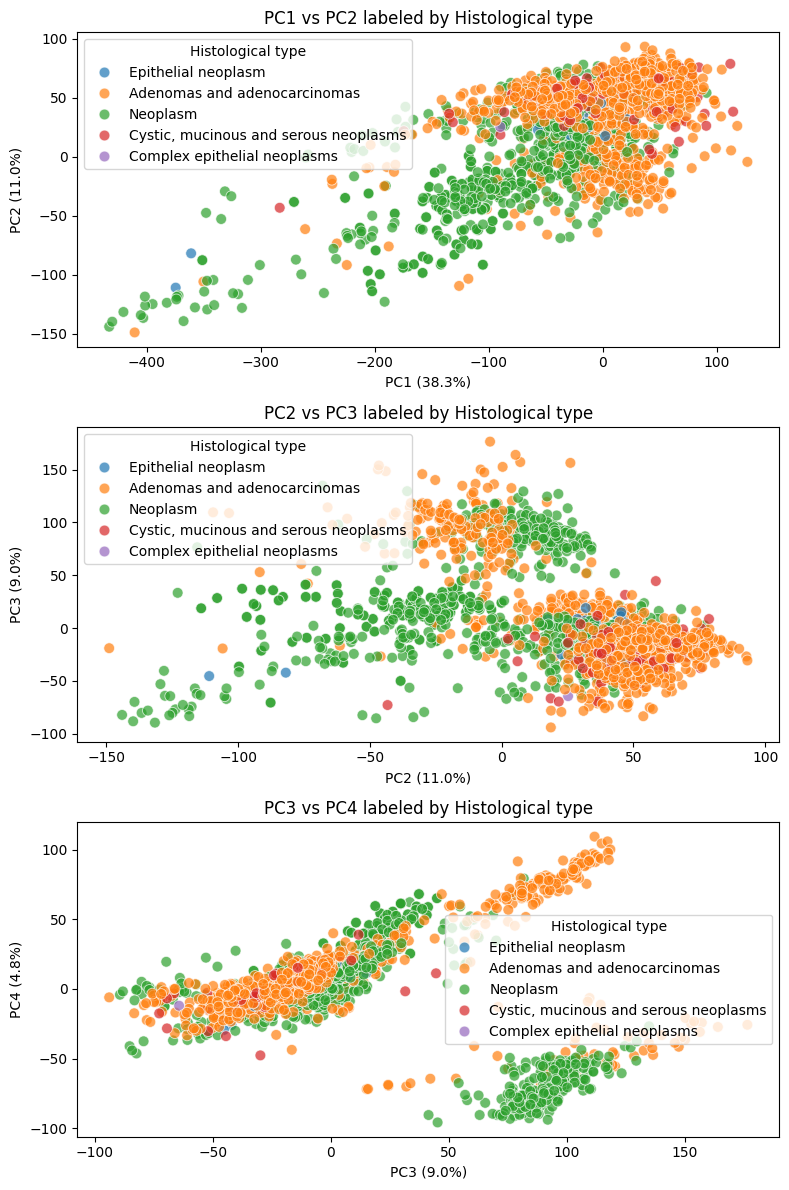

In [71]:
plotter.pca_components(pca_df_merged, pca, 'Histological type', 4)

##### Considerations: 
The PCA shows that the dataset is partitioned on Sample type: TUMOR/HEALTY and on DATASET of ORIGIN. This is on top of the batch effect correction on sample type and biopsy site.
No sign of partition by sex. I would have expected this to show but probably there is stronger signal due to sample type and batch effect of the dataset of origin. It might also be that sex signal would show up on other components.

### STEP 5: Possible analysis routes
1. Tumor vs Normal gene differential expression: 
    > BIOLOGICAL DRIVE: show which genes are more expressed or disrupted in cancer tissue compared to healthy one;  
    > DATA: all expression data + sample_type from clinical data;  
    > APPROACH: differential expression analysis with pydeseq2.  
2. Tumor stage/grade differential expression analysis:  
    > BIOLOGICAL DRIVE: show genes more/less expressed depending on tumor stage;  
    > DATA: expression data of tumor sample + tumor stage and grade.  
    > APPROACH: differential expression analysis with pydeseq2.  
3. : TUMOR MUTATIONAL/MOLECULAR singature impact on gene expression
    > BIOLOGICAL DRIVE: show gene signatures for each CMS subtype and MSI status, TMB.  
    > DATA: expression data of tumor samples + CMS, MSI, TMB and genes mutation status (might need to drop the ones with too many NANs).  
    > APPROACH: differential expression analysis with pydeseq2.  
4. Treatment Response Prediction:  
    > BIOLOGICAL DRIVE: predict therapy response from pre-treatment gene expression differences.  
    > DATA: expression data of tumor samples + Therapy response, Therapy type + Prior treatment.  
    > APPROACH: train a classifier on those data, given that the gene expression assay was conducted before treatment (but after 'prior treatment').  
5. Survial analysis:
    > BIOLOGICAL DRIVE: show which genes (+ [relationship between TMB value and overall survival](https://pmc.ncbi.nlm.nih.gov/articles/PMC8576223/)) predict patient survival.  
    > DATA: expression data + OS status, OS time, PFS status, PFS time, TMB group, (+ Stage, Grade, Age which are correlated to survival).  
    > APPROACH: 
6. Tumor location (proximal colon vs distal colon)(colon vs rectum vs ...) differential expression analysis;  
    > BIOLOGICAL DRIVE: show which genes are more/less expressed depending by ;  
    > DATA: expression data of tumor samples + sample_type from clinical data;  
    > APPROACH: differential expression analysis with pydeseq2.


### STEP 6: DIFFERENTIAL EXPRESSION ANALYSIS ON DIFFERENT TUMOR GRADE

In [72]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [73]:
print(clinical_data['Sample type'].notna().sum() / clinical_data.shape[0])

1.0


take same samples in clinical data as in metadata

In [77]:
col_to_drop

Index(['GSM1133355', 'GSM2131489', 'GSM2131490', 'GSM2131492', 'GSM2131495',
       'GSM2131497', 'GSM2131501', 'GSM2131502', 'GSM2131508', 'GSM3447676',
       'GSM3447677', 'GSM3447678', 'GSM3567225', 'GSM3567226', 'GSM4053401',
       'GSM4443967', 'GSM4443969', 'GSM4728247', 'GSM4728267', 'GSM4728268',
       'GSM4728275', 'GSM5732642', 'GSM5732656', 'GSM5732659', 'GSM5732663',
       'GSM7706418', 'GSM7706419', 'GSM7706420', 'GSM7706421', 'GSM7706422',
       'GSM7706423', 'GSM7706424', 'GSM7706425', 'GSM7706426', 'GSM7706427',
       'GSM7706428', 'GSM7706429', 'GSM7706430', 'GSM7706431', 'GSM7706432',
       'GSM7706433', 'GSM7706434', 'GSM7706435', 'GSM7706436', 'GSM7706437',
       'GSM7706438', 'GSM7706439', 'GSM7706440', 'GSM7706441', 'GSM7706442',
       'GSM7706443', 'GSM7733877', 'GSM7733924', 'GSM7733978', 'GSM7734027',
       'GSM7770481', 'TCGA-A6-2679-01A-02R-1410-07'],
      dtype='object')

In [79]:
clinical_data = clinical_data.drop(col_to_drop, axis=0)
clinical_data.shape

(2698, 28)

In [80]:
expression_data.shape

(21292, 2698)

In [102]:
expression_data = expression_data.dropna()
expression_data.shape

(21292, 2698)

In [103]:
expression_data

GSM1133352  GSM1133353  GSM2042099  GSM2042100  GSM2042101  \
A1BG             1.0         7.0         9.0        46.0       105.0   
A1BG-AS1         1.0         3.0        17.0        44.0        95.0   
A1CF            73.0         2.0       272.0       241.0       540.0   
A2M            116.0       261.0      1229.0      6595.0     16567.0   
A2M-AS1          3.0         3.0        41.0       192.0       369.0   
...              ...         ...         ...         ...         ...   
ZYG11A           1.0         5.0         0.0         7.0        24.0   
ZYG11B          37.0        20.0       441.0       229.0      2976.0   
ZYX             20.0        72.0      2393.0      3235.0      7464.0   
ZZEF1          350.0        69.0       980.0      1640.0      5398.0   
ZZZ3            36.0        41.0       304.0       296.0      3845.0   

          GSM2042102  GSM2042124  GSM2042125  GSM2042126  GSM2042127  \
A1BG            21.0        18.0        32.0        18.0        30.0   
A1BG-AS1        28.0        16.0        27.0        21.0        26.0   
A1CF           522.0      1384.0      2037.0      1468.0      1211.0   
A2M           3268.0      6031.0      7256.0      8621.0      5744.0   
A2M-AS1         83.0        64.0       104.0       114.0       114.0   
...              ...         ...         ...         ...         ...   
ZYG11A           1.0         3.0         7.0         0.0         1.0   
ZYG11B         466.0       626.0       946.0       559.0       464.0   
ZYX           3400.0       644.0       842.0       714.0      1159.0   
ZZEF1         2214.0      4279.0      5135.0      3745.0      3746.0   
ZZZ3           613.0       510.0       611.0       487.0       367.0   

          GSM2042128  GSM2042129  GSM2042130  GSM2042131  GSM2042132  \
A1BG            20.0        28.0        46.0        32.0        14.0   
A1BG-AS1        19.0        23.0        26.0        23.0        11.0   
A1CF          1208.0      1432.0      1057.0      1146.0       713.0   
A2M           3951.0      4724.0      5846.0      4117.0      8218.0   
A2M-AS1        119.0       102.0       194.0        70.0        96.0   
...              ...         ...         ...         ...         ...   
ZYG11A           1.0         1.0         3.0         3.0         2.0   
ZYG11B         395.0       612.0       360.0       466.0       364.0   
ZYX            953.0       736.0      1228.0      1041.0       486.0   
ZZEF1         3057.0      3482.0      2414.0      3694.0      2457.0   
ZZZ3           311.0       431.0       368.0       414.0       264.0   

          GSM2042133  GSM2042134  GSM2042135  GSM2042136  GSM2042137  \
A1BG            45.0        19.0        17.0         9.0        14.0   
A1BG-AS1        36.0        14.0        10.0         9.0        20.0   
A1CF          1203.0      1942.0      1413.0      1336.0      1460.0   
A2M           3827.0      8760.0      3529.0       530.0      5230.0   
A2M-AS1        100.0       115.0        74.0        36.0        93.0   
...              ...         ...         ...         ...         ...   
ZYG11A           0.0         5.0         4.0         9.0         4.0   
ZYG11B         389.0       881.0      1154.0       776.0       530.0   
ZYX            728.0      1210.0       759.0       254.0       741.0   
ZZEF1         3844.0      5638.0      5052.0      2798.0      3908.0   
ZZZ3           367.0       542.0       379.0       355.0       390.0   

          GSM2042138  GSM2042139  GSM2042140  GSM2042141  GSM2042142  \
A1BG            18.0         7.0        25.0        22.0        10.0   
A1BG-AS1        21.0        11.0        19.0        21.0        13.0   
A1CF          1214.0      1770.0      1288.0      1058.0      1067.0   
A2M           2756.0      2460.0      5349.0      2082.0      3144.0   
A2M-AS1         89.0        72.0        98.0        73.0        48.0   
...              ...         ...         ...         ...         ...   
ZYG11A           8.0         2.0         2.0  

In [104]:
if expression_data.select_dtypes(include=['object']).shape[1] > 0:
    print("Converting expression data to numeric...")
    expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
expression_data

GSM1133352  GSM1133353  GSM2042099  GSM2042100  GSM2042101  \
A1BG             1.0         7.0         9.0        46.0       105.0   
A1BG-AS1         1.0         3.0        17.0        44.0        95.0   
A1CF            73.0         2.0       272.0       241.0       540.0   
A2M            116.0       261.0      1229.0      6595.0     16567.0   
A2M-AS1          3.0         3.0        41.0       192.0       369.0   
...              ...         ...         ...         ...         ...   
ZYG11A           1.0         5.0         0.0         7.0        24.0   
ZYG11B          37.0        20.0       441.0       229.0      2976.0   
ZYX             20.0        72.0      2393.0      3235.0      7464.0   
ZZEF1          350.0        69.0       980.0      1640.0      5398.0   
ZZZ3            36.0        41.0       304.0       296.0      3845.0   

          GSM2042102  GSM2042124  GSM2042125  GSM2042126  GSM2042127  \
A1BG            21.0        18.0        32.0        18.0        30.0   
A1BG-AS1        28.0        16.0        27.0        21.0        26.0   
A1CF           522.0      1384.0      2037.0      1468.0      1211.0   
A2M           3268.0      6031.0      7256.0      8621.0      5744.0   
A2M-AS1         83.0        64.0       104.0       114.0       114.0   
...              ...         ...         ...         ...         ...   
ZYG11A           1.0         3.0         7.0         0.0         1.0   
ZYG11B         466.0       626.0       946.0       559.0       464.0   
ZYX           3400.0       644.0       842.0       714.0      1159.0   
ZZEF1         2214.0      4279.0      5135.0      3745.0      3746.0   
ZZZ3           613.0       510.0       611.0       487.0       367.0   

          GSM2042128  GSM2042129  GSM2042130  GSM2042131  GSM2042132  \
A1BG            20.0        28.0        46.0        32.0        14.0   
A1BG-AS1        19.0        23.0        26.0        23.0        11.0   
A1CF          1208.0      1432.0      1057.0      1146.0       713.0   
A2M           3951.0      4724.0      5846.0      4117.0      8218.0   
A2M-AS1        119.0       102.0       194.0        70.0        96.0   
...              ...         ...         ...         ...         ...   
ZYG11A           1.0         1.0         3.0         3.0         2.0   
ZYG11B         395.0       612.0       360.0       466.0       364.0   
ZYX            953.0       736.0      1228.0      1041.0       486.0   
ZZEF1         3057.0      3482.0      2414.0      3694.0      2457.0   
ZZZ3           311.0       431.0       368.0       414.0       264.0   

          GSM2042133  GSM2042134  GSM2042135  GSM2042136  GSM2042137  \
A1BG            45.0        19.0        17.0         9.0        14.0   
A1BG-AS1        36.0        14.0        10.0         9.0        20.0   
A1CF          1203.0      1942.0      1413.0      1336.0      1460.0   
A2M           3827.0      8760.0      3529.0       530.0      5230.0   
A2M-AS1        100.0       115.0        74.0        36.0        93.0   
...              ...         ...         ...         ...         ...   
ZYG11A           0.0         5.0         4.0         9.0         4.0   
ZYG11B         389.0       881.0      1154.0       776.0       530.0   
ZYX            728.0      1210.0       759.0       254.0       741.0   
ZZEF1         3844.0      5638.0      5052.0      2798.0      3908.0   
ZZZ3           367.0       542.0       379.0       355.0       390.0   

          GSM2042138  GSM2042139  GSM2042140  GSM2042141  GSM2042142  \
A1BG            18.0         7.0        25.0        22.0        10.0   
A1BG-AS1        21.0        11.0        19.0        21.0        13.0   
A1CF          1214.0      1770.0      1288.0      1058.0      1067.0   
A2M           2756.0      2460.0      5349.0      2082.0      3144.0   
A2M-AS1         89.0        72.0        98.0        73.0        48.0   
...              ...         ...         ...         ...         ...   
ZYG11A           8.0         2.0         2.0  

In [125]:
# Also clean the values if needed
# clinical_data['Sample_type'] = clinical_data['Sample type'].str.upper().str.strip()
clinical_data_clean = pd.DataFrame(clinical_data[['Sample_type','source']])
clinical_data_clean.columns = clinical_data_clean.columns.str.replace(' ', '_')
clinical_data_clean['Sample_type'] = clinical_data_clean['Sample_type'].str.upper().str.strip()
clinical_data_clean['Sample_type'].unique()

<StringArray>
['HEALTHY SAMPLE', 'PRIMARY CANCER']
Length: 2, dtype: string

In [112]:
expression_data.columns

Index(['GSM1133352', 'GSM1133353', 'GSM2042099', 'GSM2042100', 'GSM2042101',
       'GSM2042102', 'GSM2042124', 'GSM2042125', 'GSM2042126', 'GSM2042127',
       ...
       'TCGA-F5-6702-01A-11R-1830-07', 'TCGA-F5-6811-01A-11R-1830-07',
       'TCGA-F5-6814-01A-31R-1928-07', 'TCGA-F5-6861-01A-11R-1928-07',
       'TCGA-F5-6863-01A-11R-1928-07', 'TCGA-F5-6864-01A-11R-1928-07',
       'TCGA-G5-6233-01A-11R-1736-07', 'TCGA-G5-6235-01A-11R-1736-07',
       'TCGA-G5-6572-01A-11R-1830-07', 'TCGA-G5-6641-01A-11R-A32Z-07'],
      dtype='object', length=2698)

In [113]:
print(expression_data['GSM1133352'].dtype)

float64


In [111]:
# Get a subset of data to test
test_samples = clinical_data_clean['Sample_type'].value_counts()
print("Sample types available:", test_samples)

# Make sure we have at least 3 samples per group
if all(test_samples >= 3):
    # Get 3 samples from each group
    tumor_samples = clinical_data_clean[clinical_data_clean['Sample_type'] == 'TUMOR'].index[:3]
    normal_samples = clinical_data_clean[clinical_data_clean['Sample_type'] == 'HEALTHY'].index[:3]
    
    test_samples = list(tumor_samples) + list(normal_samples)
    
    # Create test datasets
    test_expression = expression_data[test_samples].iloc[:1000]  # First 1000 genes
    test_clinical = clinical_data_clean.loc[test_samples]
    
    print(f"\nTest data: {len(test_samples)} samples, {test_expression.shape[0]} genes")
    
    # Try with test data
    dds_test = DeseqDataSet(
        counts=test_expression.T,
        metadata=test_clinical,
        design="~ Sample_type",
        refit_cooks=True
    )
    
    print("Test DESeq2 dataset created successfully!")
    


Sample types available: Sample_type
PRIMARY CANCER    1893
HEALTHY SAMPLE     805
Name: count, dtype: Int64

Test data: 0 samples, 1000 genes


UFuncTypeError: Cannot cast ufunc 'svd' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

In [126]:
# ---> FIX: Explicitly convert the column to category dtype <---
clinical_data_clean['Sample_type'] = clinical_data_clean['Sample_type'].astype('category')
clinical_data_clean['source'] = clinical_data_clean['source'].astype('category')
# It's also a good practice to check for any missing values
print(clinical_data_clean.isnull().sum())

# Now, initialize the DeseqDataSet
# This should work without error
dds_tn = DeseqDataSet(
    counts=expression_data.T,
    metadata=clinical_data_clean,
    design="~Sample_type",
    refit_cooks=True,
    n_cpus=16
)

Sample_type    0
source         0
dtype: int64


In [128]:
dds_tn = DeseqDataSet(
    counts=expression_data.T,  
    metadata=clinical_data_clean,
    design="~ source + Sample_type",  # batch correction for dataset
    refit_cooks=True,
    n_cpus=16
)

In [129]:
print("Running DESeq2 for Tumor vs Normal...")
dds_tn.deseq2()

Running DESeq2 for Tumor vs Normal...
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 1.30 seconds.

Fitting dispersions...
... done in 12.58 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 12.74 seconds.

Fitting LFCs...
... done in 8.94 seconds.

Calculating cook's distance...
... done in 3.24 seconds.

Replacing 2086 outlier genes.

Fitting dispersions...
... done in 1.55 seconds.

Fitting MAP dispersions...
... done in 1.45 seconds.

Fitting LFCs...
... done in 1.87 seconds.



In [130]:
# Get results
stat_res_tn = DeseqStats(
    dds_tn, 
    contrast=["Sample_type", "PRIMARY CANCER", "HEALTHY SAMPLE"]
)
stat_res_tn.summary()
results_tn = stat_res_tn.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: Sample_type PRIMARY CANCER vs HEALTHY SAMPLE
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
A1BG         68.862086        1.466025  0.319277   4.591707  4.396350e-06   
A1BG-AS1     37.757227        0.659491  0.267461   2.465743  1.367294e-02   
A1CF        702.302769       -1.498102  0.375450  -3.990155  6.603013e-05   
A2M       11120.787292        0.058747  0.199746   0.294110  7.686741e-01   
A2M-AS1     156.551733        0.458504  0.258145   1.776147  7.570873e-02   
...                ...             ...       ...        ...           ...   
ZYG11A       25.468396        2.500014  0.425453   5.876122  4.199890e-09   
ZYG11B     1132.310987       -0.292667  0.118241  -2.475183  1.331680e-02   
ZYX        8262.599479        2.269136  0.206780  10.973654  5.116194e-28   
ZZEF1      3649.740939       -0.890546  0.153242  -5.811378  6.196078e-09   
ZZZ3       1238.945855        0.737525  0.111057   6.640976  3.116124e

... done in 1.85 seconds.



In [131]:
# Filter significant genes
sig_tn = results_tn[
    (results_tn['padj'] < 0.05) & 
    (abs(results_tn['log2FoldChange']) > 1)
]
print(f"\nTumor vs Normal: {len(sig_tn)} significant DEGs")
print(f"Upregulated in tumor: {len(sig_tn[sig_tn['log2FoldChange'] > 0])}")
print(f"Downregulated in tumor: {len(sig_tn[sig_tn['log2FoldChange'] < 0])}")

# Save results
sig_tn.sort_values('padj').to_csv('tumor_vs_normal_DEGs.csv')


Tumor vs Normal: 8317 significant DEGs
Upregulated in tumor: 6987
Downregulated in tumor: 1330


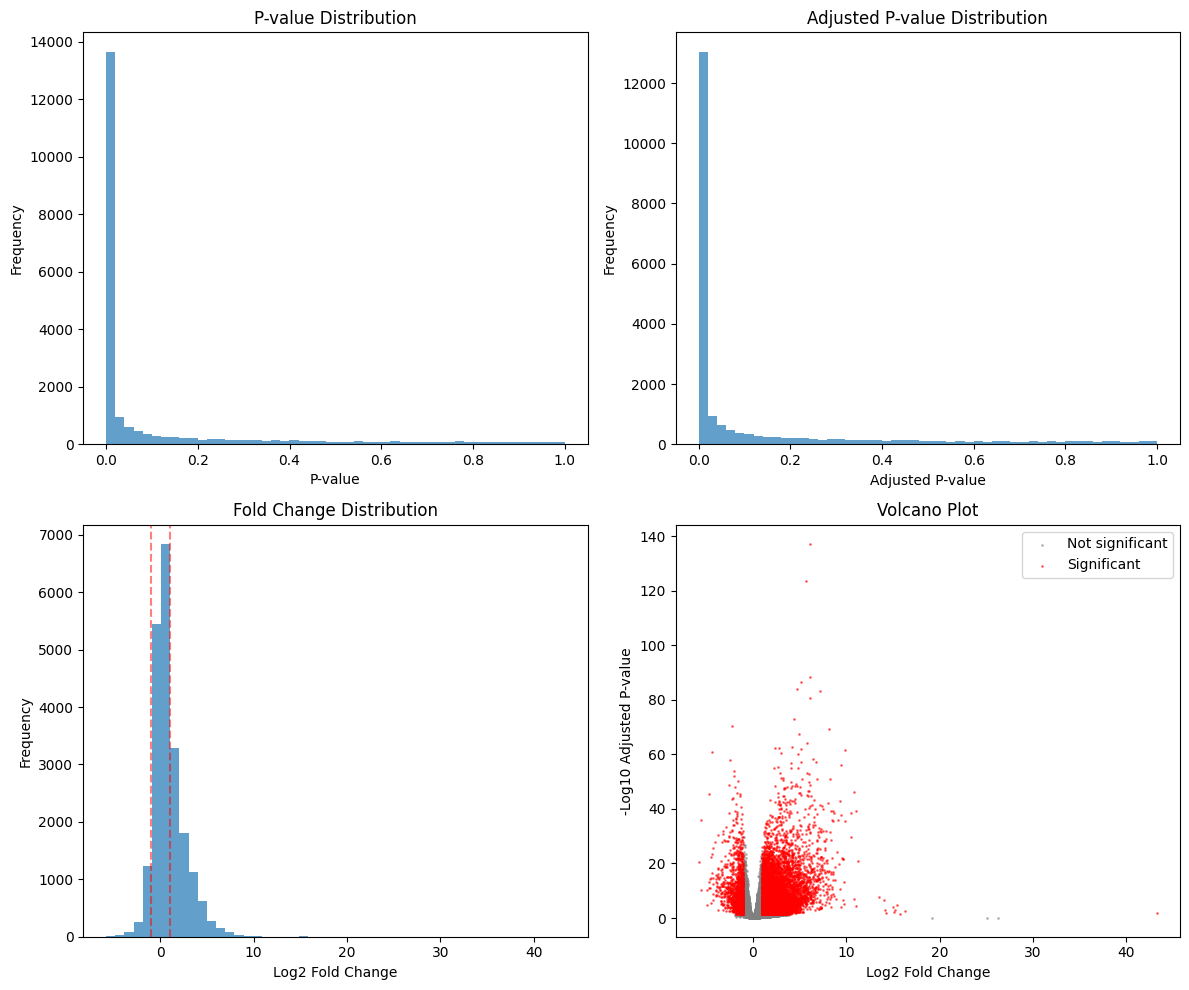

Fold change statistics:
Mean log2FC (significant genes): 2.00
Median log2FC (significant genes): 1.93
Max log2FC: 43.28
Min log2FC: -5.79


In [133]:
# Look at the p-value distribution
import matplotlib.pyplot as plt
results = results_tn
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# P-value histogram
ax = axes[0, 0]
ax.hist(results['pvalue'].dropna(), bins=50, alpha=0.7)
ax.set_xlabel('P-value')
ax.set_ylabel('Frequency')
ax.set_title('P-value Distribution')

# Adjusted p-value histogram
ax = axes[0, 1]
ax.hist(results['padj'].dropna(), bins=50, alpha=0.7)
ax.set_xlabel('Adjusted P-value')
ax.set_ylabel('Frequency')
ax.set_title('Adjusted P-value Distribution')

# Log2 fold change distribution
ax = axes[1, 0]
ax.hist(results['log2FoldChange'].dropna(), bins=50, alpha=0.7)
ax.axvline(x=1, color='red', linestyle='--', alpha=0.5)
ax.axvline(x=-1, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('Frequency')
ax.set_title('Fold Change Distribution')

# Volcano plot
ax = axes[1, 1]
sig_mask = (results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1)
ax.scatter(results.loc[~sig_mask, 'log2FoldChange'], 
           -np.log10(results.loc[~sig_mask, 'padj']), 
           alpha=0.5, s=1, c='gray', label='Not significant')
ax.scatter(results.loc[sig_mask, 'log2FoldChange'], 
           -np.log10(results.loc[sig_mask, 'padj']), 
           alpha=0.5, s=1, c='red', label='Significant')
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('-Log10 Adjusted P-value')
ax.set_title('Volcano Plot')
ax.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("Fold change statistics:")
print(f"Mean log2FC (significant genes): {results.loc[sig_mask, 'log2FoldChange'].mean():.2f}")
print(f"Median log2FC (significant genes): {results.loc[sig_mask, 'log2FoldChange'].median():.2f}")
print(f"Max log2FC: {results['log2FoldChange'].max():.2f}")
print(f"Min log2FC: {results['log2FoldChange'].min():.2f}")

In [135]:
from sklearn.decomposition import PCA

# Get normalized counts from DESeq2
normalized_counts = dds_tn.vst_data.T  # genes x samples

# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(normalized_counts.T)

# Create a figure with multiple PCAs colored by different factors
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# PC1 vs PC2 colored by Sample_type
ax = axes[0, 0]
for sample_type in clinical_data_filtered['Sample_type'].unique():
    mask = clinical_data_filtered['Sample_type'] == sample_type
    ax.scatter(pca_result[mask, 0], pca_result[mask, 1], 
               label=sample_type, alpha=0.7, s=50)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA by Sample Type')
ax.legend()

# PC1 vs PC2 colored by source (batch)
if 'source' in clinical_data_filtered.columns:
    ax = axes[0, 1]
    for source in clinical_data_filtered['source'].unique():
        mask = clinical_data_filtered['source'] == source
        ax.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   label=source, alpha=0.7, s=50)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax.set_title('PCA by Data Source')
    ax.legend()

plt.tight_layout()
plt.show()

AttributeError: 'DeseqDataSet' object has no attribute 'vst_data'

In [ ]:
dds_batch = DeseqDataSet(
    counts=expression_filtered.T,
    metadata=metadata_filtered,
    design="~ source + Sample_type",  # Batch correction for source
    refit_cooks=True,
    n_cpus=8
)

dds_batch.deseq2()

# Get batch-corrected results
stat_res_batch = DeseqStats(
    dds_batch,
    contrast=["Sample_type", "TUMOR", "HEALTHY"]
)
stat_res_batch.summary()
results_batch = stat_res_batch.results_df

In [ ]:
# For biopsy site comparisons (tumor samples only)
tumor_only = clinical_data_clean[clinical_data_clean['Sample_type'] == 'TUMOR']
expression_tumor = expression_data.loc[:, tumor_only.index]

# Check available biopsy sites
print("\nBiopsy sites:")
print(tumor_only['Biopsy_site'].value_counts())

# Compare specific sites (e.g., Colon vs Liver)
sites_to_compare = ['Colon', 'Liver']
site_mask = tumor_only['Biopsy_site'].isin(sites_to_compare)
expression_sites = expression_tumor.loc[:, site_mask]
metadata_sites = tumor_only[site_mask].copy()

# Create DESeq2 dataset for site comparison
dds_sites = DeseqDataSet(
    counts=expression_sites.T,
    metadata=metadata_sites,
    design="~ source + Biopsy_site",  # Correct for dataset source
    refit_cooks=True,
    n_cpus=8
)

dds_sites.deseq2()

# Get results
stat_res_sites = DeseqStats(
    dds_sites,
    contrast=["Biopsy_site", "Liver", "Colon"]
)
stat_res_sites.summary()
results_sites = stat_res_sites.results_df